$\textbf{*** This version uses built-in function to load data}$

In [1]:
import sys
import importlib
sys.path.append('../')

from src.finance_ml.denoising.denoising import Denoising
from src.finance_ml.indicators.indicators import Indicators
from src.finance_ml.volatility.volatility import Volatility

In [2]:
# Import required packages
import pandas as pd
import numpy as np

from pyarrow.parquet import ParquetFile
import pyarrow as pa

import matplotlib.pyplot as plt
import seaborn as sns

import math

In [10]:
data_cols = ['DATE', 'OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW', 'VOLUME']

var_cols = ['OPEN', 'HIGHT', 'LOW', 'CLOSE', 'VW', 'VOLUME', 'CLOSE_returns', 
            'CLOSE_log_returns', 'CLOSE_price_change','CLOSE_pct_change', 
            'RA_5', 'RA_10', 'AMPL', 'OPNCLS', 'MA_5', 'MA_10','V_MA_5', 
            'V_MA_10', 'V_MA_20']

normvar_cols = ['N_OPEN', 'N_HIGHT', 'N_LOW', 'N_CLOSE', 'N_VW', 'N_VOLUME',
               'N_CLOSE_returns', 'N_CLOSE_log_returns', 'N_CLOSE_price_change',
                'N_CLOSE_pct_change', 'N_RA_5', 'N_RA_10', 'N_AMPL', 'N_OPNCLS', 
                'N_MA_5', 'N_MA_10','N_V_MA_5', 'N_V_MA_10', 'N_V_MA_20']

vol_cols = ['CorwinSchultz', 'HodgesTompkins', 'YangZhang', 'RogersSatchell', 'GarmanKlass']

file_path = '../../Work Group Topics/Intraday_Market_Data/'
fname_RUBEUR = 'FX/RUBEUR_2020-04-07_2022-04-06.parquet'
fname_USDBRL = 'FX/USDBRL_2020-04-07_2022-04-06.parquet'
fname_AAPL = 'equities/AAPL_2020-04-07_2022-04-06.parquet'

## Reading the Data File

In [11]:
def readMarketData(fname:str, n=10000):
    # Testing Data
    pf = ParquetFile(file_path+fname)
    first_ten_rows = next(pf.iter_batches(batch_size = n)) 
    df = pa.Table.from_batches([first_ten_rows]).to_pandas()
    return df

In [12]:
df = readMarketData(fname_AAPL)
display(df)

,VOLUME,VW,OPEN,CLOSE,HIGHT,LOW,t,TRANSACTIONS,a,op,DATE
0,14256.0,67.3454,67.3500,67.3375,67.3625,67.3275,1586261820000,45,NaN,NaN,2020-04-07 12:17:00
1,16552.0,67.3407,67.3501,67.3250,67.3625,67.3250,1586261880000,57,NaN,NaN,2020-04-07 12:18:00
2,80172.0,67.3937,67.3250,67.4225,67.4475,67.3250,1586261940000,149,NaN,NaN,2020-04-07 12:19:00
3,183740.0,67.3671,67.4475,67.3700,67.4700,67.3125,1586262000000,159,NaN,NaN,2020-04-07 12:20:00
4,35372.0,67.3469,67.3500,67.2975,67.3850,67.2975,1586262060000,102,NaN,NaN,2020-04-07 12:21:00
...,...,...,...,...,...,...,...,...,...,...,...
9995,255044.0,70.7960,70.7875,70.7700,70.8256,70.7673,1587997320000,851,NaN,NaN,2020-04-27 14:22:00
9996,412688.0,70.7800,70.7675,70.7899,70.8221,70.7500,1587997380000,1204,NaN,NaN,2020-04-27 14:23:00
9997,268616.0,70.7815,70.7925,70.7625,70.8063,70.7550,1587997440000,652,NaN,NaN,2020-04-27 14:24:00
9998,336820.0,70.7436,70.7625,70.7475,70.7675,70.7225,1587997500000,1015,NaN,NaN,2020-04-27 14:25:00


In [13]:
df.columns

Index(['VOLUME', 'VW', 'OPEN', 'CLOSE', 'HIGHT', 'LOW', 't', 'TRANSACTIONS',
       'a', 'op', 'DATE'],
      dtype='object')

# Data Augmentation

In order to increase the number of variables considered in the covariance matrix, this module introduced some sample $\textit{indicators}$ and $\textit{volatility}$ indexes calculated over the asset's data.

After $\textbf{Volatility}$ and $\textbf{Data Generation}$ groups introduced the appropriate classes, we can eliminate this portion of code and dependencies.

## Calculate Indicators

In [14]:
# Process data normalization
norm_data = True

# Select Indicator transformer
ind_processor = Indicators(df, norm_data = norm_data)

# Calculate Indicators over input dataframe
df = ind_processor.transform(df)

# Display output dataframe
display(df[var_cols+normvar_cols if norm_data else var_cols])

,OPEN,HIGHT,LOW,CLOSE,VW,VOLUME,CLOSE_returns,CLOSE_log_returns,CLOSE_price_change,CLOSE_pct_change,...,N_CLOSE_pct_change,N_RA_5,N_RA_10,N_AMPL,N_OPNCLS,N_MA_5,N_MA_10,N_V_MA_5,N_V_MA_10,N_V_MA_20
0,67.3500,67.3625,67.3275,67.3375,67.3454,14256.0,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,-0.955200,0.448370,-0.402877,-0.403680,-0.990748,-0.986876,-0.981787
1,67.3501,67.3625,67.3250,67.3250,67.3407,16552.0,0.999814,-0.000186,-0.0125,-0.000186,...,0.052788,NaN,NaN,-0.952000,0.434674,-0.404166,-0.404980,-0.989972,-0.985744,-0.980171
2,67.3250,67.4475,67.3250,67.4225,67.3937,80172.0,1.001448,0.001447,0.0975,0.001448,...,0.133112,NaN,NaN,-0.843200,0.567935,-0.397893,-0.398655,-0.975374,-0.964448,-0.949776
3,67.4475,67.4700,67.3125,67.3700,67.3671,183740.0,0.999221,-0.000779,-0.0525,-0.000779,...,0.023633,NaN,NaN,-0.798400,0.377717,-0.397463,-0.398222,-0.950568,-0.928261,-0.898125
4,67.3500,67.3850,67.2975,67.2975,67.3469,35372.0,0.998924,-0.001077,-0.0725,-0.001076,...,0.009008,-0.895969,NaN,-0.888000,0.404891,-0.400196,-0.400977,-0.955748,-0.935818,-0.908912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,70.7875,70.8256,70.7673,70.7700,70.7960,255044.0,0.999753,-0.000247,-0.0175,-0.000247,...,0.049760,-0.853382,-0.882482,-0.925376,0.442935,0.321871,0.330506,-0.779435,-0.688084,-0.467131
9996,70.7675,70.8221,70.7500,70.7899,70.7800,412688.0,1.000281,0.000281,0.0199,0.000281,...,0.075738,-0.859099,-0.874211,-0.907712,0.486304,0.317226,0.328126,-0.759667,-0.682613,-0.479664
9997,70.7925,70.8063,70.7550,70.7625,70.7815,268616.0,0.999613,-0.000387,-0.0274,-0.000387,...,0.042885,-0.864194,-0.863633,-0.934336,0.429348,0.312325,0.325215,-0.761712,-0.690905,-0.499406
9998,70.7625,70.7675,70.7225,70.7475,70.7436,336820.0,0.999788,-0.000212,-0.0150,-0.000212,...,0.051493,-0.961580,-0.847886,-0.942400,0.445652,0.305415,0.323083,-0.764809,-0.687118,-0.504024


## Calculate Volatility Indicators

In [15]:
# Select Volatility transformer
vol_processor = Volatility(df)

# Calculate Volatility over input dataframe
df = vol_processor.transform(df)

# Display output dataframe
display(df[vol_cols])

,CorwinSchultz,HodgesTompkins,YangZhang,RogersSatchell,GarmanKlass
0,NaN,NaN,NaN,NaN,NaN
1,0.000495,NaN,NaN,NaN,NaN
2,0.000201,NaN,NaN,NaN,NaN
3,0.001506,NaN,NaN,NaN,NaN
4,0.000275,NaN,NaN,NaN,NaN
...,...,...,...,...,...
9995,0.000050,0.013090,0.014687,0.232834,0.014276
9996,0.000584,0.012940,0.014686,0.233239,0.014284
9997,0.000559,0.012048,0.013874,0.220619,0.013481
9998,0.000000,0.012024,0.013609,0.215887,0.013167


## Data Preparation

In [16]:
X = np.array(df[normvar_cols+vol_cols if norm_data else var_cols+vol_cols])[30:]

## Denoising the Covariance Matrix

In [17]:
# Instanciate the Denoising transformer
denoise_processor = Denoising()

# Calculates Correlation, Covariance, EigenValues and EigenVectors of denoised covariance matrix
cov1, corr1, eVal1, eVec1 = denoise_processor.transform(X)

# Calculates non-denoised Covariance Matrix
cov0 = np.cov(X,rowvar=0)
corr0 = Denoising.cov2corr(cov0)

## Visualization or results

In [18]:
#----- Comparison between Non-Denoised and Denoised Cov Matrices
def plotHeatMaps (corr0, corr1, txt: str):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.subplots_adjust(wspace=1)

    sns.set(font_scale=0.6)

    sns.heatmap(corr0, cmap="plasma", ax=ax1, cbar=True)
    sns.heatmap(corr1, cmap="plasma", ax=ax2, cbar=True)

    # ax2.yaxis.tick_right()

    ax1.set_title('non-denoised', fontsize=12)
    ax2.set_title('denoised '+txt, fontsize=12)

    fig.subplots_adjust(wspace=0.001)
    plt.show()


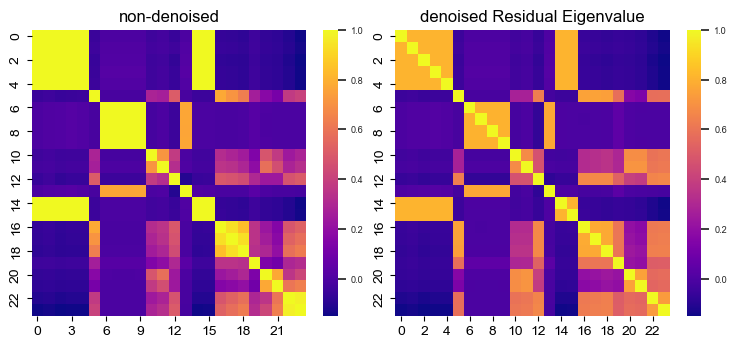

In [19]:
# Compare the correlation matrix before and after denoising
plotHeatMaps(corr0, corr1, 'Residual Eigenvalue')

# Calculate Marchenko-Pastur Density

The objective of the fit is to find the value of $\sigma^2$ that minimizes the sum of the squared differences between the analytical PDF and the kernel density estimate (KDE) of the observed eigenvalues.

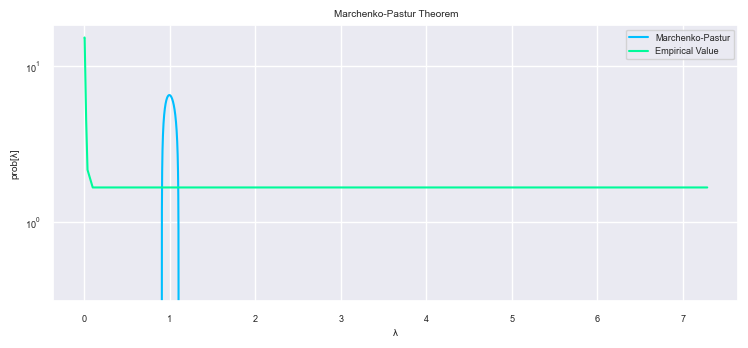

In [20]:
# Instanciate Marcenko Pastur processor
marcpastur_processor = Denoising(q=X.shape[0]/float(X.shape[1]))  #, pts=X.shape[1])

# Getting eigenvalues and eigenvectors
eVal0, eVec0 = marcpastur_processor.getPCA(corr0)

# Marchenko-Pastur pdf
pdf0 = marcpastur_processor.mpPDF(1.)

# Empirical pdf
pdf1= marcpastur_processor.fitKDE(np.diag(eVal0))

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.set_yscale('log')
ax.legend(loc="upper right")

## Eigen Values compared with Marcenko Pastur distribution

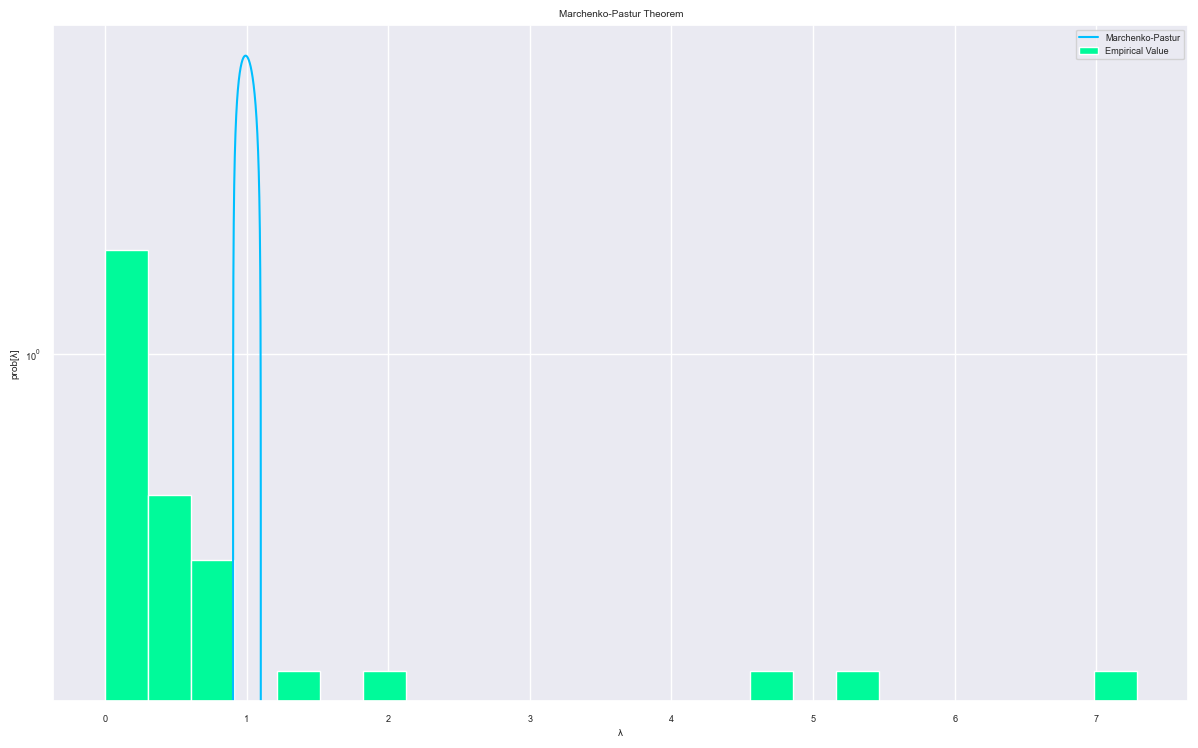

In [21]:
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = marcpastur_processor.getPCA(corr0)

# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = marcpastur_processor.findMaxEval(np.diag(eVal0))
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

# Getting PDFs and plotting it
pdf0 = marcpastur_processor.mpPDF(var0)

# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(12,7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=X.shape[1], label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.set_yscale('log')
ax.legend(loc="upper right")

Eigenvalues to the right of the fitted Marcenko–Pastur distribution cannot be associated with noise, thus they are
related to signal.

# Monte Carlo Simulation

Adapted from Chap. 2 of $\textit{Machine Learning for Asset Managers}$, by Marcos M. Lopez de Prado - 1st. edition


This block of code reproduces the example to compute the errors with estimating a minimum variance portfolio with and without noising.

## Generating Block Diagonal Matrix

I this block we generate a vector of means and a covariance matrix out of ten blocks of size fifty each, where offdiagonal
elements within each block have a correlation of 0.5. This covariance matrix is a stylized representation of a true (nonempirical) detoned correlation matrix of the $\textbf{S&P 500}$, where each block is associated with an economic sector. 

Variances are drawn from uniform distribution bounded $[.05, .2]$ and the means sampled from a Standard Normal distribution. This is consistent with the notion that in an efficient market all securities have the same expected Sharpe ratio.

In [22]:
from scipy.linalg import block_diag

# SNIPPET 2.7 GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS
def formBlockMatrix(nBlocks,bSize,bCorr): 
    block = np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr = block_diag(*([block]*nBlocks)) 
    return corr
#--------------------------------------------------- 
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0 = formBlockMatrix(nBlocks,bSize,bCorr) 
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0 = corr0[cols].loc[cols].copy(deep=True) 
    std0 = np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0 = Denoising.corr2cov(corr0,std0) 
    mu0 = np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1) 
    return mu0,cov0

## Generating Empirical Covariance Matrix

Now, $\textbf{Lopez}$ uses the true (nonempirical) covariance matrix to draw a random matrix $\tilde{X}$ of size $T\times N$, and it derives the associated empirical covariance matrix and vector of means.

In [23]:
from sklearn.covariance import LedoitWolf

# SNIPPET 2.8 GENERATING THE EMPIRICAL COVARIANCE MATRIX
def simCovMu(mu0, cov0, nObs, shrink=False): 
    x = np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1 = x.mean(axis = 0).reshape(-1,1)
    if shrink:
        cov1 = LedoitWolf().fit(x).covariance_ 
    else:
        cov1 = np.cov(x,rowvar=0)
    return mu1,cov1

### Denoising the Empirical Cov Matrix

Here, Lopez applies the denoising routine to denoise the empirical covariance matrix. In this particular experiment, we denoise through the $\textit{constant residual eigenvalue}$ method.

In [24]:
# SNIPPET 2.9 DENOISING OF THE EMPIRICAL COVARIANCE MATRIX
#--------------------------------------------------- 
def deNoiseCov(cov0,d_transf):
    corr0 = Denoising.cov2corr(cov0)
    eVal0,eVec0 = d_transf.getPCA(corr0) 
    eMax0,var0 = d_transf.findMaxEval(np.diag(eVal0)) 
    nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0) 
    corr1 = d_transf.denoisedCorr(eVal0,eVec0,nFacts0) 
    cov1 = Denoising.corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [25]:
#----- Generating Block Diagonal Cov Matrix and Vector of Means
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [26]:
#----- Generating Empirical Cov Matrix
mu1, cov1 = simCovMu(mu0,cov0,1000,shrink=True)

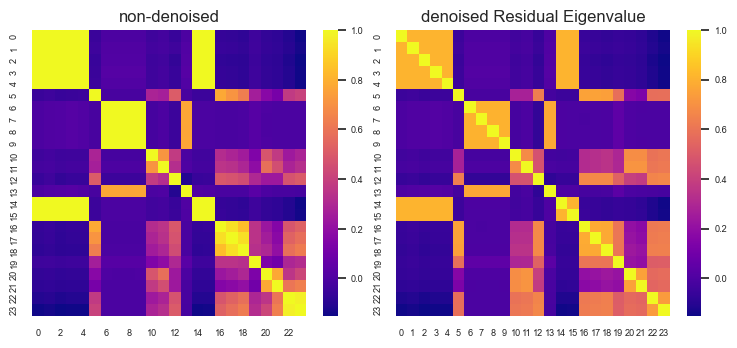

In [27]:
# Compare the correlation matrix before and after denoising
plotHeatMaps(corr0, corr1, 'Residual Eigenvalue')

### Simulation

This runs the following $\textit{Monte Carlo experiment}$ with $1,000$ iterations: (1) draw a random empirical covariance matrix (shrinkage optional) with $T=1,000$; (2) denoise the empirical covariance matrix (optional); (3) derive the minimum variance portfolio, using the function $\texttt{optPort}$. When we pass the argument shrink=True to function $\texttt{simCovMu}$, the covariance matrix is shrunk.

In [28]:
def optPort(cov,mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0],1))
    if mu is None:
        mu = ones
    w = np.dot(inv,mu)
    w /= np.dot(ones.T,w)
    return w
#---------------------------------------------------
nObs,nTrials,bWidth,shrink,minVarPortf=1000,100,.01,False,True

mc_processor = Denoising(q=nObs*1./cov1.shape[1])

w1 = pd.DataFrame(columns=range(cov0.shape[0]),
        index = range(nTrials),dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1,cov1 = simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf: 
        mu1 = None
    cov1_d = deNoiseCov(cov1,mc_processor)
    w1.loc[i] = optPort(cov1,mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d,mu1).flatten()

Following the simulation, Lopez computes the true minimum variance portfolio, derived from the true covariance matrix. Using those allocations as benchmark, it then computes the root-mean-square errors (RMSE) across all weights, with and
without denoising.

In [29]:
#----- Root Mean Errors
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(f"Total RSME:")
print("-----------\n")
print(f"Non-Denoised {rmsd*100:.4f}% | Denoised {rmsd_d*100:.4f}%")
print(f"Ratio: {rmsd_d/rmsd:.4f}")

Total RSME:
-----------

Non-Denoised 0.4993% | Denoised 0.1138%
Ratio: 0.2278
